# Лабораторная работа №6
Пресняцкий Виктор, гр. 956241, вариант 5

## Классификация на основе обработки текстовой информации. Рекуррентные нейронные сети. Полносвязные сети с предобучением.


Дан набор данных из Keras: IMDB (Internet Movie Database) - множеством из 50000 самых разных отзывов к кинолентам в интернет-базе фильмов. Набор разбит на 25 000 обучающих и 25 000 контрольных отзывов, каждый набор на 50% состоит из отрицательных и на 50% из положительных отзывов.
Необходимо решить задачу классификации фильмов на положительные и отрицательные, опираясь на текст отзывов.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.experimental import PeepholeLSTMCell

In [2]:
MAX_FEATURES = 10000
MAX_LEN = 200

Производим загрузку и подготовку данных.

In [3]:
(X_train_loaded, y_train), (X_test_loaded, y_test) = keras.datasets.imdb.load_data(num_words=MAX_FEATURES)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [5]:
print(f'Train data shape: {X_train_loaded.shape}, {y_train.shape}')
print(f'Test data shape: {X_test_loaded.shape}, {y_test.shape}')

Train data shape: (25000,), (25000,)
Test data shape: (25000,), (25000,)


Производим смешение данных так, чтобы их тензоры приняли одинаковую размерность.

In [6]:
print(len(X_train_loaded[0]) == len(X_train_loaded[-1]))
X_train = keras.preprocessing.sequence.pad_sequences(X_train_loaded, maxlen=MAX_LEN)
X_test = keras.preprocessing.sequence.pad_sequences(X_test_loaded, maxlen=MAX_LEN)
print(len(X_train[0]) == len(X_train[-1]))
X_train[-1]

False
True


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    1,   17,    6,  194,  337,    7,    4,  204,
         22,   45,  254,    8,  106,   14,  123,    4,    2,  270,    2,
          5,    2,    2,  732, 2098,  101,  405,   39,   14, 1034,    4,
       1310,    9,  115,   50,  305,   12,   47,    4,  168,    5,  235,
          7,   38,  111,  699,  102,    7,    4, 4039, 9245,    9,   24,
          6,   78, 1099,   17, 2345,    2,   21,   27, 9685, 6139,    5,
          2, 1603,   92, 1183,    4, 1310,    7,    4,  204,   42,   97,
         90,   35,  221,  109,   29,  127,   27,  118,    8,   97,   12,
        157,   21, 6789,    2,    9,    6,   66,   78, 1099,    4,  631,
       1191,    5, 2642,  272,  191, 1070,    6, 75

In [7]:
def show_history(history):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Задание 1.
Построить рекуррентную нейронную сеть на базе слоев:

В.5. LSTM c peepholes connections

Выполнить обучение построенной сети для решения задачи классификации фильмов на положительные и отрицательные, опираясь на текст отзывов. 
Выполнить при этом оценки точности обучения и валидации, а также ошибки потерь. Построить соответствующие графики.

In [23]:
def build_lstm_model(embedding_dim=150):
    model = keras.models.Sequential([
        keras.layers.Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN),
        keras.layers.Bidirectional(keras.layers.RNN(PeepholeLSTMCell(128))),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [24]:
lstm_model = build_lstm_model()
best_lstm_model_path = 'lstm_model.h5'
checkpoint_callback = ModelCheckpoint(best_lstm_model_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint_callback]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/recurrent.py:2560: UserWarning: `tf.keras.experimental.PeepholeLSTMCell` is deprecated and will be removed in a future version. Please use tensorflow_addons.rnn.PeepholeLSTMCell instead.
  warnings.warn('`tf.keras.experimental.PeepholeLSTMCell` is deprecated '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 150)          1500000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               286464    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 1,786,721
Trainable params: 1,786,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
313/313 [==============================] - 516s 2s/step - loss: 0.5574 - accuracy: 0.6941 - val_loss: 0.3669 - val_accuracy: 0.8546

Epoch 00001: val_accuracy improved from -inf to 0.85460, saving model to lstm_model.h5
Epoch 2/5
313/313 [==============================] - 512s 2s/step - loss: 0.3419 - accuracy: 0.8648 - val_loss: 0.3551 - val_accuracy: 0.8612

E

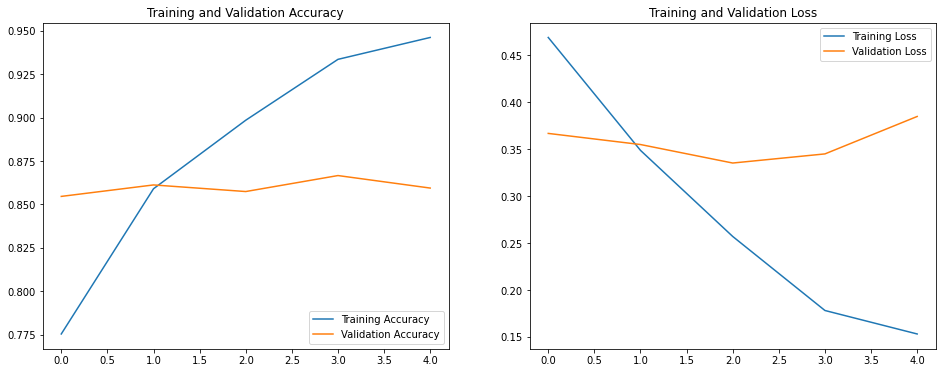

In [25]:
show_history(lstm_history)

In [27]:
lstm_test_model = keras.models.load_model(best_lstm_model_path)
lstm_test_accuracy = lstm_test_model.evaluate(X_test, y_test, verbose=0)[1]
print(f'Test accuracy LSTM network with peephole connections: {lstm_test_accuracy * 100:.2f}%')

Test accuracy LSTM network with peephole connections: 86.35%


#### Задание 2.
Построить полносвязную нейронную сеть, позволяющую решить поставленную задачу классификации (пример см. в лекциях). Для улучшения точности обучения и валидации использовать метод:

В.5. преобучения без учителя с применением автокодировщика.

In [57]:
EMBEDDING_DIM = 150


def prepare_initial_X(X, initial_samples_count=1000):
    model = keras.models.Sequential([
        keras.layers.Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=MAX_LEN, trainable=False),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
    ])
    X_ini = model.predict(X[:initial_samples_count])
    return X_ini


def build_auto_encoder_layers(X):
    verbose = 0
    lr_reduction = ReduceLROnPlateau(
        monitor='loss',
        patience=3, 
        verbose=verbose, 
        factor=0.3, 
        min_lr=1e-5
    )

    neurons_on_layers = [EMBEDDING_DIM * MAX_LEN, 64, 32]

    auto_encoder_layers = []
    cur_X = prepare_initial_X(X)

    for i in range(len(neurons_on_layers) - 1):
        input_layer = neurons_on_layers[i]
        output_layer = neurons_on_layers[i + 1]
        auto_encoder = keras.models.Sequential([
            keras.layers.Dense(output_layer, activation='tanh', bias_regularizer='l2'),
            keras.layers.Dense(input_layer, activation='linear', bias_regularizer='l2'),
        ])
        auto_encoder.compile(loss='mean_squared_error', optimizer='adam')
        auto_encoder.fit(cur_X, cur_X, epochs=50, callbacks=[lr_reduction], verbose=verbose)

        cur_model = keras.models.Sequential()
        cur_layer = auto_encoder.layers.pop(0)
        cur_model.add(cur_layer)
        cur_X = cur_model.predict(cur_X)
        auto_encoder_layers.append(cur_layer)
        print(f'{i + 1} layer generated')

    return auto_encoder_layers


def build_ae_dense_model(auto_encoder_layers):
    model = keras.models.Sequential([
        keras.layers.Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=MAX_LEN),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation='relu', weights=auto_encoder_layers[0].get_weights()),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu', weights=auto_encoder_layers[1].get_weights()),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [58]:
auto_encoder_layers = build_auto_encoder_layers(X_train)
ae_dense_model = build_ae_dense_model(auto_encoder_layers)

1 layer generated
2 layer generated


In [59]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.3, 
                                 min_lr=1e-5)

best_ae_dense_model_path = 'ae_dense_model.h5'
checkpoint_callback = ModelCheckpoint(best_ae_dense_model_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history = ae_dense_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[lr_reduction, checkpoint_callback]
)

Epoch 1/5
313/313 [==============================] - 7s 21ms/step - loss: 0.7932 - accuracy: 0.5514 - val_loss: 0.5866 - val_accuracy: 0.8172

Epoch 00001: val_accuracy improved from -inf to 0.81720, saving model to ae_dense_model.h5
Epoch 2/5
313/313 [==============================] - 6s 20ms/step - loss: 0.2966 - accuracy: 0.8829 - val_loss: 0.3411 - val_accuracy: 0.8624

Epoch 00002: val_accuracy improved from 0.81720 to 0.86240, saving model to ae_dense_model.h5
Epoch 3/5
313/313 [==============================] - 6s 20ms/step - loss: 0.1294 - accuracy: 0.9568 - val_loss: 0.4031 - val_accuracy: 0.8568

Epoch 00003: val_accuracy did not improve from 0.86240
Epoch 4/5
313/313 [==============================] - 6s 20ms/step - loss: 0.0568 - accuracy: 0.9822 - val_loss: 0.5398 - val_accuracy: 0.8454

Epoch 00004: val_accuracy did not improve from 0.86240
Epoch 5/5
313/313 [==============================] - 6s 20ms/step - loss: 0.0421 - accuracy: 0.9856 - val_loss: 0.5718 - val_accuracy

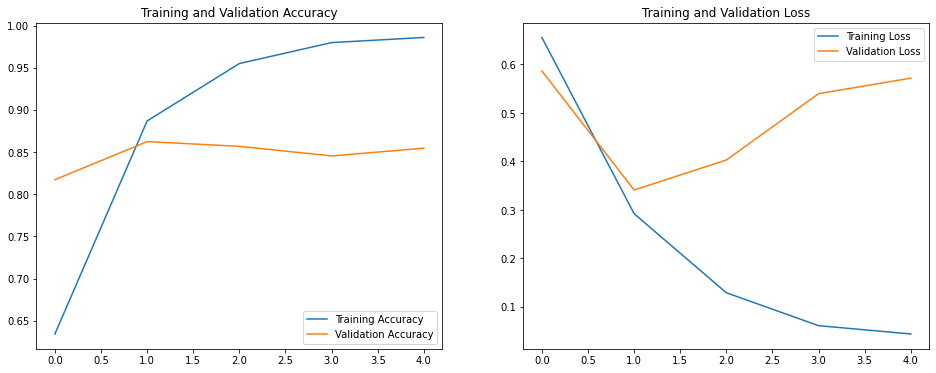

In [60]:
show_history(history)

In [61]:
ae_dense_test_model = keras.models.load_model(best_ae_dense_model_path)
ae_dense_test_accuracy = ae_dense_test_model.evaluate(X_test, y_test, verbose=0)[1]
print(f'Test accuracy of fully connected network with autoencoder: {ae_dense_test_accuracy * 100:.2f}%')

Test accuracy of fully connected network with autoencoder: 85.09%


Задание 3. Сравнить полученные точности для построенных рекуррентной и полносвязной сетей.

In [62]:
print(f'Test accuracy LSTM network with peephole connections: {lstm_test_accuracy * 100:.2f}%')
print(f'Test accuracy of fully connected network with autoencoder: {ae_dense_test_accuracy * 100:.2f}%')

Test accuracy LSTM network with peephole connections: 86.35%
Test accuracy of fully connected network with autoencoder: 85.09%


Из результатов видно, что LSTM сеть работает на 1.3% точнее.